In [4]:
# Import necessary libraries
import pandas as pd
import sqlite3

In [5]:
# Sqlite connection:
conn = sqlite3.connect('data_analysis_assignment.db')
cursor = conn.cursor()

In [6]:
# Now we'll load the CSV files:
file_paths = ["Users.csv", "products.csv", "Transactions.csv"]
for i, file_path in enumerate(file_paths, start=1):
    # Load CSV into Pandas
    df = pd.read_csv(file_path)
    
    # Remove any whitespace from column headers
    df.columns = df.columns.str.strip()
    
    # Save to SQLite with unique table names
    table_name = f"table_{i}"
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print(f"Loaded {file_path} into table {table_name}")

Loaded Users.csv into table table_1
Loaded products.csv into table table_2
Loaded Transactions.csv into table table_3


In [7]:
# Custom function to check data quality issues in each table
def data_quality_checks(table_name):
    print(f"\nData Quality Checks for {table_name}:")

    # Check for missing values
    query = f"SELECT * FROM {table_name} LIMIT 5"
    df = pd.read_sql(query, conn)
    print("Sample Data:\n", df.head())
    
    # Check for nulls in each column
    query = f"SELECT COUNT(*) as total_rows, " \
            + ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls" for col in df.columns]) \
            + f" FROM {table_name}"
    null_counts = pd.read_sql(query, conn)
    print("Missing Values:\n", null_counts)

    # Check for duplicates using a count on unique rows (ROWID workaround)
    query = f"SELECT COUNT(*) as total_rows, COUNT(DISTINCT ROWID) as unique_rows FROM {table_name}"
    duplicates = pd.read_sql(query, conn)
    print("Duplicate Rows:\n", duplicates)

    # Check data types and possible anomalies in each column
    for col in df.columns:
        query = f"SELECT DISTINCT typeof({col}) as type FROM {table_name}"
        types = pd.read_sql(query, conn)
        print(f"Column '{col}' Types:\n", types)

# Run quality checks on each table
for i in range(1, 4):
    data_quality_checks(f"table_{i}")



Data Quality Checks for table_1:
Sample Data:
                          ID               CREATED_DATE  \
0  5ef3b4f17053ab141787697d  2020-06-24 20:17:54.000 Z   
1  5ff220d383fcfc12622b96bc  2021-01-03 19:53:55.000 Z   
2  6477950aa55bb77a0e27ee10  2023-05-31 18:42:18.000 Z   
3  658a306e99b40f103b63ccf8  2023-12-26 01:46:22.000 Z   
4  653cf5d6a225ea102b7ecdc2  2023-10-28 11:51:50.000 Z   

                  BIRTH_DATE STATE LANGUAGE  GENDER  
0  2000-08-11 00:00:00.000 Z    CA   es-419  female  
1  2001-09-24 04:00:00.000 Z    PA       en  female  
2  1994-10-28 00:00:00.000 Z    FL   es-419  female  
3                       None    NC       en    None  
4  1972-03-19 00:00:00.000 Z    PA       en  female  
Missing Values:
    total_rows  ID_nulls  CREATED_DATE_nulls  BIRTH_DATE_nulls  STATE_nulls  \
0      100000         0                   0              3675         4812   

   LANGUAGE_nulls  GENDER_nulls  
0           30508          5892  
Duplicate Rows:
    total_rows  uniqu

In [8]:
# To highlight the inconsistent values in users table, column gender:
from IPython.display import display
query = """
    SELECT GENDER
    FROM table_1
    WHERE GENDER IS NOT NULL
    GROUP BY GENDER
"""
# Execute the query and load results into a DataFrame
gender_data = pd.read_sql(query, conn)

styled_data = gender_data.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]}
]).set_properties(**{'text-align': 'center'})

# Display the styled DataFrame
display(styled_data)

# print(gender_data)

,GENDER
0,My gender isn't listed
1,Non-Binary
2,Prefer not to say
3,female
4,male
5,non_binary
6,not_listed
7,not_specified
8,prefer_not_to_say
9,transgender


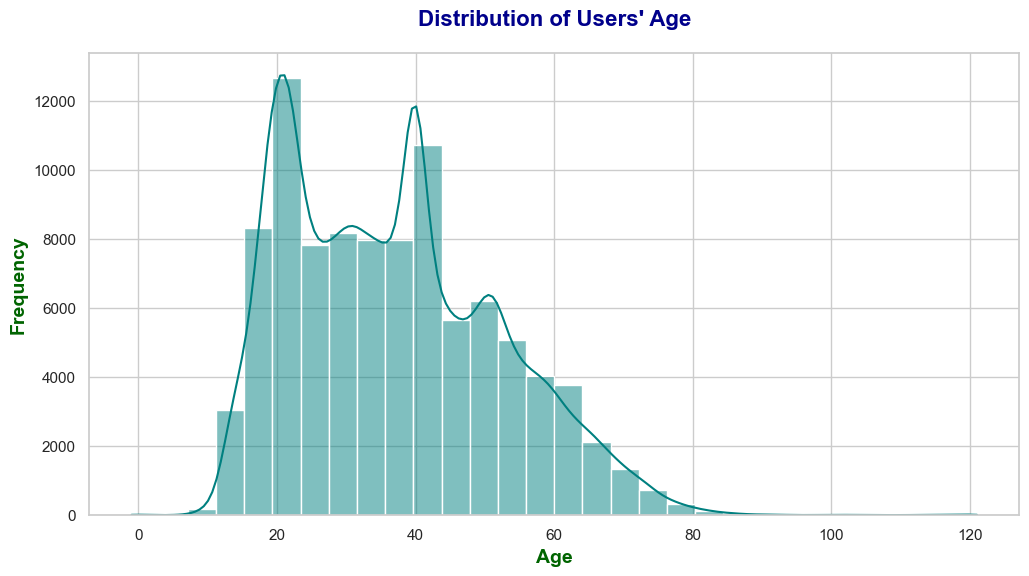

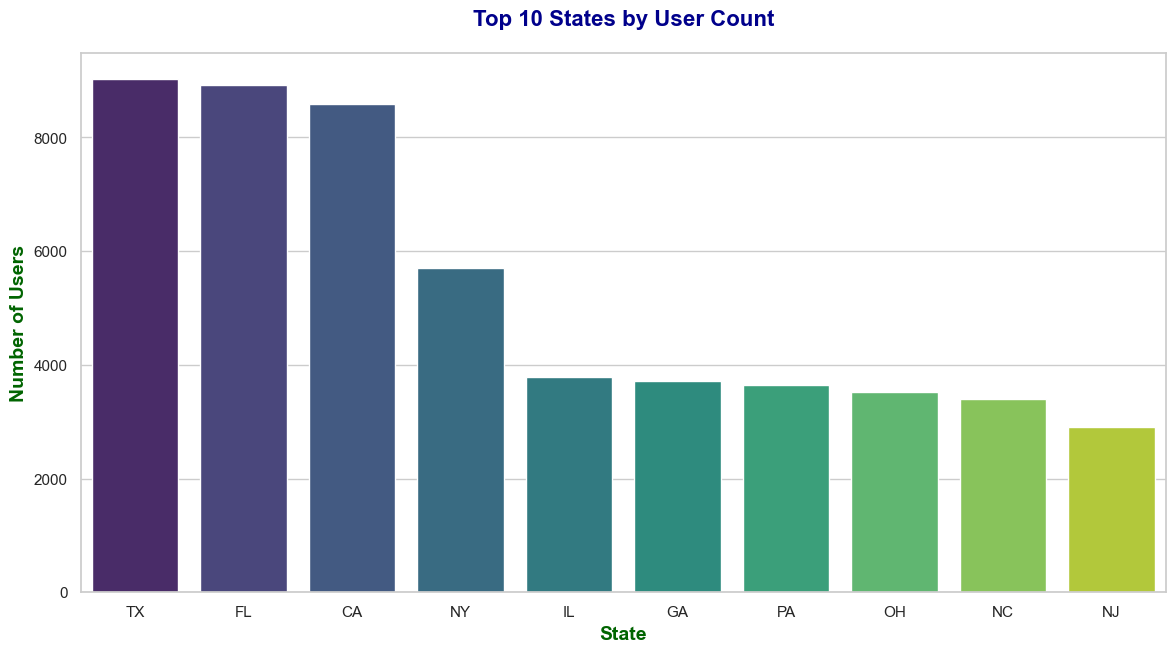

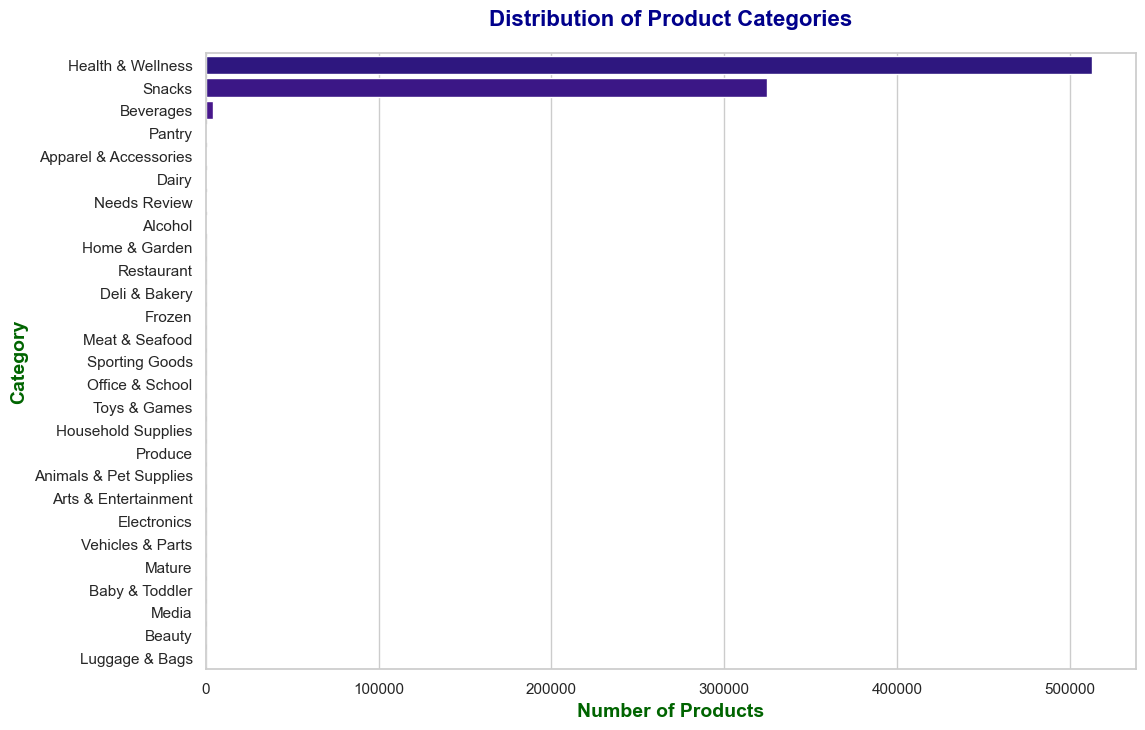

In [9]:
# Data Visualization on unstructured data
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting for Jupyter Notebooks
%matplotlib inline

# Set Seaborn style
sns.set(style='whitegrid')

# Visualization 1: Distribution of Users' Age
# Calculate age from BIRTH_DATE (assuming CREATED_DATE is the reference)
query = """
    SELECT ID, CREATED_DATE, BIRTH_DATE,
           (strftime('%Y', CREATED_DATE) - strftime('%Y', BIRTH_DATE)) -
           (strftime('%m-%d', CREATED_DATE) < strftime('%m-%d', BIRTH_DATE)) AS age
    FROM table_1
    WHERE BIRTH_DATE IS NOT NULL
"""
age_data = pd.read_sql(query, conn)

# Plot age distribution
plt.figure(figsize=(12, 6))
sns.histplot(age_data['age'].dropna(), bins=30, kde=True, color='teal')
plt.title('Distribution of Users\' Age', fontsize=16, fontweight='bold', color='darkblue', pad=20)
plt.xlabel('Age', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Frequency', fontsize=14, fontweight='bold', color='darkgreen')
plt.show()

# Visualization 2: Top 10 States by User Count
query = """
    SELECT STATE, COUNT(*) as user_count
    FROM table_1
    WHERE STATE IS NOT NULL
    GROUP BY STATE
    ORDER BY user_count DESC
    LIMIT 10
"""
state_data = pd.read_sql(query, conn)

# Plot Top 10 States by User Count
plt.figure(figsize=(14, 7))
sns.barplot(data=state_data, x='STATE', y='user_count', palette='viridis')
plt.title('Top 10 States by User Count', fontsize=16, fontweight='bold', color='darkblue', pad=20)
plt.xlabel('State', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Number of Users', fontsize=14, fontweight='bold', color='darkgreen')
plt.show()

# Visualization 3: Category Distribution in the Products Table
query = """
    SELECT CATEGORY_1, COUNT(*) as category_count
    FROM table_2
    WHERE CATEGORY_1 IS NOT NULL
    GROUP BY CATEGORY_1
    ORDER BY category_count DESC
"""
category_data = pd.read_sql(query, conn)

# Plot Category Distribution
plt.figure(figsize=(12, 8))
sns.barplot(data=category_data, y='CATEGORY_1', x='category_count', palette='plasma')
plt.title('Distribution of Product Categories', fontsize=16, fontweight='bold', color='darkblue', pad=20)
plt.xlabel('Number of Products', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Category', fontsize=14, fontweight='bold', color='darkgreen')
plt.show()




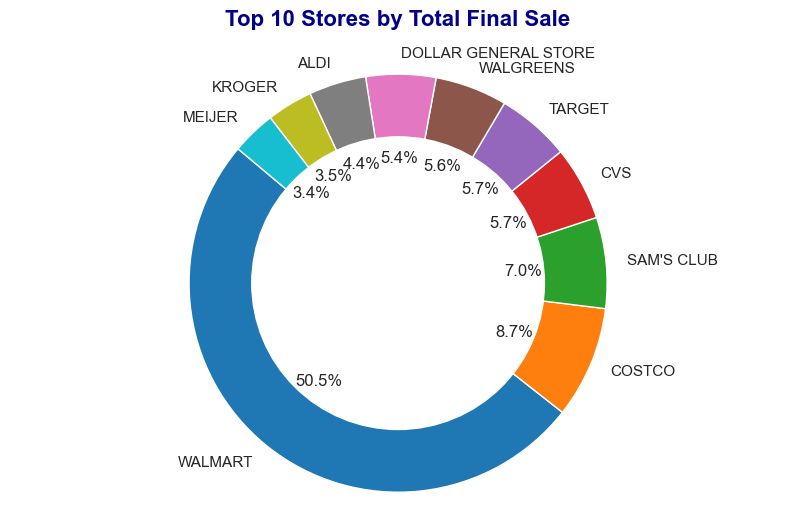

In [10]:
# Visualization 4
# Query to get top 10 stores by total final sale
query = """
SELECT STORE_NAME, SUM(FINAL_SALE) as total_sales
FROM table_3
GROUP BY STORE_NAME
ORDER BY total_sales DESC
LIMIT 10
"""
top_stores_sales = pd.read_sql(query, conn)

# Clean data to avoid TypeErrors during plotting
top_stores_sales = top_stores_sales.dropna(subset=['STORE_NAME'])
top_stores_sales['total_sales'] = pd.to_numeric(top_stores_sales['total_sales'], errors='coerce')
top_stores_sales = top_stores_sales.dropna(subset=['total_sales'])

# Plotting top 10 stores by total final sale as a donut chart
if not top_stores_sales.empty:
    plt.figure(figsize=(10, 6))
    
    # Create a pie chart
    wedges, texts, autotexts = plt.pie(top_stores_sales['total_sales'], 
                                        labels=top_stores_sales['STORE_NAME'], 
                                        autopct='%1.1f%%', 
                                        startangle=140, 
                                        colors=plt.cm.tab10.colors)
    
    # Draw a circle at the center of pie to make it a donut chart
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.title("Top 10 Stores by Total Final Sale", 
              fontsize=16,  # Increase font size
              fontweight='bold',  # Make it bold
              color='darkblue',  # Change color
              pad=20)  # Added padding for space
    plt.show()
else:
    print("No valid data available for plotting top stores by total final sale.")


In [11]:

# Function to create a new table with appropriate data types
def create_new_table(table_name, schema, new_table_name):
    # Drop the table if it already exists
    cursor.execute(f"DROP TABLE IF EXISTS {new_table_name}")

    # Create new table with defined schema
    cursor.execute(f"CREATE TABLE {new_table_name} ({schema})")

    # Insert data from old table to the new one with data cleaning
    cursor.execute(f"INSERT INTO {new_table_name} SELECT * FROM {table_name}")
    conn.commit()
    print(f"Created and populated {new_table_name} with cleaned data.")

# Creating 'users_new' table with appropriate data types
users_schema = """
    ID TEXT PRIMARY KEY,
    CREATED_DATE TEXT,
    BIRTH_DATE TEXT,
    STATE TEXT,
    LANGUAGE TEXT,
    GENDER TEXT
"""
create_new_table('table_1', users_schema, 'users_new')

# Creating 'products_new' table with appropriate data types
products_schema = """
    CATEGORY_1 TEXT,
    CATEGORY_2 TEXT,
    CATEGORY_3 TEXT,
    CATEGORY_4 TEXT,
    MANUFACTURER TEXT,
    BRAND TEXT,
    BARCODE TEXT
"""
create_new_table('table_2', products_schema, 'products_new')

# Creating 'transactions_new' table with appropriate data types
transactions_schema = """
    RECEIPT_ID TEXT,
    PURCHASE_DATE TEXT,
    SCAN_DATE TEXT,
    STORE_NAME TEXT,
    USER_ID TEXT,
    BARCODE TEXT,
    FINAL_QUANTITY INTEGER,
    FINAL_SALE REAL
"""
create_new_table('table_3', transactions_schema, 'transactions_new')

# Closing the database connection
conn.close()

Created and populated users_new with cleaned data.
Created and populated products_new with cleaned data.
Created and populated transactions_new with cleaned data.


In [12]:
# Function to fill missing values in 'users_new', 'products_new' and 'transactions_new' table

def fill_missing_values_users(conn):
    # Loading data from 'users_new' table
    users_df = pd.read_sql("SELECT * FROM users_new", conn)

    # Filling the missing values with the most common (mode) values
    if not users_df['BIRTH_DATE'].isnull().all():
        most_common_birth_date = users_df['BIRTH_DATE'].mode()[0]
        users_df['BIRTH_DATE'].fillna(most_common_birth_date, inplace=True)

    if not users_df['STATE'].isnull().all():
        most_common_state = users_df['STATE'].mode()[0]
        users_df['STATE'].fillna(most_common_state, inplace=True)

    if not users_df['LANGUAGE'].isnull().all():
        most_common_language = users_df['LANGUAGE'].mode()[0]
        users_df['LANGUAGE'].fillna(most_common_language, inplace=True)

    if not users_df['GENDER'].isnull().all():
        most_common_gender = users_df['GENDER'].mode()[0]
        users_df['GENDER'].fillna(most_common_gender, inplace=True)

    # Save the cleaned data back to the 'users_new' table
    users_df.to_sql('users_new', conn, if_exists='replace', index=False)
    print("Filled missing values for 'users_new' table and saved.")
    
    
def fill_missing_values_products(conn):
    # Loading data from 'products_new' table
    products_df = pd.read_sql("SELECT * FROM products_new", conn)

    # Filling the missing values with the most common (mode) values
    if not products_df['CATEGORY_1'].isnull().all():
        most_common_category_1 = products_df['CATEGORY_1'].mode()[0]
        products_df['CATEGORY_1'].fillna(most_common_category_1, inplace=True)

    if not products_df['CATEGORY_2'].isnull().all():
        most_common_category_2 = products_df['CATEGORY_2'].mode()[0]
        products_df['CATEGORY_2'].fillna(most_common_category_2, inplace=True)

    if not products_df['CATEGORY_3'].isnull().all():
        most_common_category_3 = products_df['CATEGORY_3'].mode()[0]
        products_df['CATEGORY_3'].fillna(most_common_category_3, inplace=True)

    if not products_df['CATEGORY_4'].isnull().all():
        most_common_category_4 = products_df['CATEGORY_4'].mode()[0]
        products_df['CATEGORY_4'].fillna(most_common_category_4, inplace=True)

    if not products_df['MANUFACTURER'].isnull().all():
        most_common_manufacturer = products_df['MANUFACTURER'].mode()[0]
        products_df['MANUFACTURER'].fillna(most_common_manufacturer, inplace=True)

    if not products_df['BRAND'].isnull().all():
        most_common_brand = products_df['BRAND'].mode()[0]
        products_df['BRAND'].fillna(most_common_brand, inplace=True)
        
    '''
    Ensure BARCODE is cleaned
    Converts each barcode to a string and strips any leading or trailing whitespace, to avoid potential issue,
    when joining the queries
    products_df['BARCODE'] = products_df['BARCODE'].apply(lambda x: str(x).strip() if pd.notna(x) else None)
    '''

    # Save the cleaned data back to the 'products_new' table
    products_df.to_sql('products_new', conn, if_exists='replace', index=False)
    print("Filled missing values for 'products_new' table and saved.")
    
    
def fill_missing_values_transactions(conn):
    # Loading data from 'transactions_new' table
    transactions_df = pd.read_sql("SELECT * FROM transactions_new", conn)

    # Filling the FINAL_QUANTITY with the mode (most common value)
    if not transactions_df['FINAL_QUANTITY'].isnull().all():
        most_common_quantity = transactions_df['FINAL_QUANTITY'].mode()[0]
        transactions_df['FINAL_QUANTITY'].fillna(most_common_quantity, inplace=True)

    # Convert FINAL_SALE to numeric, forcing non-numeric to NaN
    transactions_df['FINAL_SALE'] = pd.to_numeric(transactions_df['FINAL_SALE'], errors='coerce')

    # Fill FINAL_SALE with the median value (more appropriate for financial data)
    if not transactions_df['FINAL_SALE'].isnull().all():
        median_final_sale = transactions_df['FINAL_SALE'].median()
        transactions_df['FINAL_SALE'].fillna(median_final_sale, inplace=True)
    
    # Ensure BARCODE is cleaned
    transactions_df['BARCODE'] = transactions_df['BARCODE'].apply(lambda x: str(x).strip() if pd.notna(x) else None)

    # Save the cleaned data back to the 'transactions_new' table
    transactions_df.to_sql('transactions_new', conn, if_exists='replace', index=False)
    print("Filled missing values for 'transactions_new' table and saved.")

# Call the functions for each table again
conn = sqlite3.connect('data_analysis_assignment.db')
fill_missing_values_users(conn)
fill_missing_values_products(conn)
fill_missing_values_transactions(conn)


Filled missing values for 'users_new' table and saved.
Filled missing values for 'products_new' table and saved.
Filled missing values for 'transactions_new' table and saved.


In [13]:
# Top 5 Brands by Receipts Scanned Among Users 21 and Over

# We are using joins to extract the results by checking the difference between the user's birth date and the scan date
# to calculate the age of the users.

query = """
SELECT p.BRAND, COUNT(t.RECEIPT_ID) AS receipts_scanned
FROM transactions_new t
JOIN users_new u ON t.USER_ID = u.ID
JOIN products_new p ON t.BARCODE = p.BARCODE
WHERE (strftime('%Y', t.SCAN_DATE) - strftime('%Y', u.BIRTH_DATE)) - 
      (strftime('%m-%d', t.SCAN_DATE) < strftime('%m-%d', u.BIRTH_DATE)) >= 21
GROUP BY p.BRAND
ORDER BY receipts_scanned DESC
LIMIT 5;
"""

top_brands_df = pd.read_sql(query, conn)

print(top_brands_df)


             BRAND  receipts_scanned
0        REM BRAND                 6
1      NERDS CANDY                 6
2             DOVE                 6
3          TRIDENT                 4
4  SOUR PATCH KIDS                 4


In [14]:
# What are the top 5 brands by sales among users who have had their account for at least six months?

# We are utilizing the created_at field in the user table in comparison to the current date to determine
# the duration of the user account.

query = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
FROM transactions_new t
JOIN users_new u ON t.USER_ID = u.ID
JOIN products_new p ON t.BARCODE = p.BARCODE
WHERE u.CREATED_DATE <= date('now', '-6 months')
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 5;
"""

top_brands = pd.read_sql(query, conn)

print(top_brands)

         BRAND  total_sales
0          CVS        75.00
1         DOVE        48.88
2      TRIDENT        46.72
3  COORS LIGHT        34.96
4    REM BRAND        22.65


In [17]:
# Which is the leading brand in the Dips & Salsa category?

query = """
SELECT p.BRAND, SUM(t.FINAL_SALE) AS total_sales
FROM transactions_new t
JOIN products_new p ON t.BARCODE = p.BARCODE
WHERE p.CATEGORY_2 = 'Dips & Salsa'
GROUP BY p.BRAND
ORDER BY total_sales DESC
LIMIT 1;
"""

leading_brand = pd.read_sql(query, conn)

print(leading_brand)

      BRAND  total_sales
0  TOSTITOS       320.99


In [19]:
# Additional codes to export the newly filled data:
#List of tables to export
tables = ['users_new', 'products_new', 'transactions_new']

# Loop through each table and save it as a CSV
for table in tables:
    df = pd.read_sql(f"SELECT * FROM {table}", conn)
    df.to_csv(f"{table}.csv", index=False)
    print(f"Exported {table} to {table}.csv")


Exported users_new to users_new.csv
Exported products_new to products_new.csv
Exported transactions_new to transactions_new.csv
